# Quroa Duplicate Question Classification Bert

## Question Semantic similarity 

* Find How similar two questions are ; are they duplicate

## Helpful Downloads and Installation

In [1]:
!git clone https://github.com/shadab4150/tez.git

Cloning into 'tez'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (320/320), done.
remote: Compressing objects: 100% (224/224), done.
remote: Total 320 (delta 164), reused 218 (delta 75), pack-reused 0
Receiving objects: 100% (320/320), 56.20 KiB | 11.24 MiB/s, done.
Resolving deltas: 100% (164/164), done.


In [2]:
tez_path = '/content/tez/'
import sys
sys.path.append(tez_path)

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 74 bytes


In [4]:
!pip uninstall kaggle -y
!pip install -qq kaggle

Uninstalling kaggle-1.5.10:
  Successfully uninstalled kaggle-1.5.10
     |████████████████████████████████| 61kB 8.1MB/s 


In [5]:
!kaggle competitions download -c quora-question-pairs

 96% 297M/309M [00:02<00:00, 144MB/s]
100% 309M/309M [00:02<00:00, 131MB/s]


In [6]:
!unzip '/content/quora-question-pairs.zip'
!unzip '/content/train.csv.zip'
!unzip '/content/test.csv.zip'

Archive:  /content/quora-question-pairs.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv                
  inflating: test.csv.zip            
  inflating: train.csv.zip           
Archive:  /content/train.csv.zip
  inflating: train.csv               
Archive:  /content/test.csv.zip
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                


In [7]:
!pip install -qq transformers

     |████████████████████████████████| 1.8MB 15.8MB/s 
     |████████████████████████████████| 890kB 58.4MB/s 
     |████████████████████████████████| 3.2MB 56.2MB/s 


## Importing Libraries

In [8]:
import tez
import transformers
import torch
import sys
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from pathlib import Path

In [22]:
trn_df = pd.read_csv('train.csv')

In [23]:
path = Path('/content')

In [24]:
trn_df.sample(n=5)

,id,qid1,qid2,question1,question2,is_duplicate
135793,135793,216794,216795,"Why CS, being professional course in India, is...",What would be it's value in Indian market if I...,0
395498,395498,528490,528491,What kind of work people do from ECE backgroun...,What is the experience like working as an engi...,0
37287,37287,67866,67028,How can we read people's mind?,How can I read a human mind?,1
279202,279202,398594,398595,Which are websites which offer Free online cer...,What makes the AR15 such a popular rifle?,0
249680,249680,58494,298813,Which are some of the biggest mistakes you hav...,What is the biggest mistake you have done in y...,1


In [25]:
trn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Stratified KFOLD

In [26]:
from sklearn.model_selection import StratifiedKFold

In [27]:
trn_df['kfold'] = -1
trn_df = trn_df.sample(frac=1.)
y = trn_df['is_duplicate'].values
skf = StratifiedKFold(n_splits=20)
for fld, (trn_,val_) in enumerate(skf.split(X=trn_df,y=y)):
    trn_df.loc[val_,'kfold'] = fld

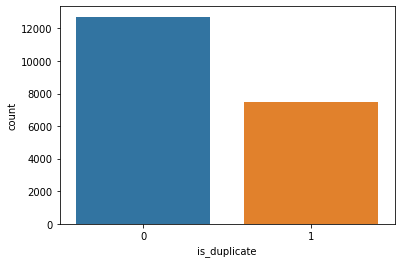

In [28]:
sns.countplot(x=trn_df[trn_df.kfold==1].is_duplicate);

## Cleaning the Text

In [29]:
import re
import nltk
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')

def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    # Clean the text, with the option to remove stopwords and to stem words.
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        text = [w for w in text if not w in STOPWORDS]
    
    text = " ".join(text)
    
    # Remove punctuation from text
    # text = "".join([c for c in text if c not in punctuation])

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    # text = re.sub(r"\0s", "0", text) # It doesn't make sense to me
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
val_df = trn_df[trn_df.kfold==3].copy() # valid
train_df = trn_df[trn_df.kfold<3].copy() # train 
ts_df = trn_df[trn_df.kfold==8].copy() # test

In [33]:
train_df.shape,val_df.shape

((60645, 7), (20215, 7))

In [34]:
#train_df['question1'] = train_df['question1'].apply(lambda x: text_to_wordlist(str(x), remove_stopwords=False))
#train_df['question2'] = train_df['question2'].apply(lambda x: text_to_wordlist(str(x), remove_stopwords=False))
#val_df['question1'] = val_df['question1'].apply(lambda x: text_to_wordlist(str(x), remove_stopwords=False))
#val_df['question2'] = val_df['question2'].apply(lambda x: text_to_wordlist(str(x), remove_stopwords=False))

In [35]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate,kfold
588,588,1174,1175,How do I work with machine learning researcher...,How can undergraduate help with machine learni...,0,0
22456,22456,17746,14730,How do i get started on machine learning?,What are some good books or references to get ...,1,1
54175,54175,94845,95667,How do I become an expert coder?,What should be the stratergy to be a great coder?,1,2
31707,31707,58439,58440,What is called simple living style?,What is the mantra to live a simple life?,0,1
37295,37295,37964,67879,How can I stop myself from spending more time ...,How can I stop myself from wasting time on the...,1,1


## DataLoader

In [57]:
from transformers import AdamW,get_linear_schedule_with_warmup
import sklearn.metrics as sklm

In [58]:
class BERTDataset:
    def __init__(self, texts1,texts2, targets,max_len=64):
        self.texts1 = texts1
        self.texts2 = texts2
        self.targets = targets
        self.tokenizer = transformers.BertTokenizer.from_pretrained(
            "bert-base-cased",
            do_lower_case=False
        )
        self.max_len = max_len
    
    def __len__(self):
        return min(len(self.texts1),len(self.texts2))

    def __getitem__(self,idx):
        
        text1 = str(self.texts1[idx])
        text2 = str(self.texts2[idx])
        
        text1 = " ".join(text1.split())
        text2 = " ".join(text2.split())
        
        inputs = self.tokenizer.encode_plus(
            text1,
            text2,
            add_special_tokens=True,
            max_length=self.max_len,
            padding="max_length",
            truncation=True
            )
        
        resp = {
            "ids" :  torch.tensor(inputs["input_ids"],dtype=torch.long),
            "mask" : torch.tensor(inputs["attention_mask"],dtype=torch.long),
            "token_type_ids" : torch.tensor(inputs["token_type_ids"],dtype=torch.long),
            "targets" : torch.tensor(self.targets[idx],dtype=torch.float)
        }

        return resp


In [59]:
train_dataset = BERTDataset(train_df.question1.values,train_df.question2.values,train_df.is_duplicate.values)
valid_dataset = BERTDataset(val_df.question1.values,val_df.question2.values,val_df.is_duplicate.values)

In [60]:
test_dataset = BERTDataset(ts_df.question1.values,ts_df.question2.values,ts_df.is_duplicate.values)

In [61]:
train_dataset[0]

{'ids': tensor([ 101, 1731, 1202,  146, 1250, 1114, 3395, 3776, 6962, 1170, 7477,  136,
          102, 1731, 1169, 8448, 1494, 1114, 3395, 3776, 1844,  136,  102,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]),
 'mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'targets': tensor(0.),
 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

In [62]:
input1 = torch.randn(100, 128)
input2 = torch.randn(100, 128)
nn.MSELoss()(input1, input2)

tensor(2.0024)

## Question Similarity Model

In [63]:
class QuestionModel(tez.Model):
    
    def __init__(self,num_classes,num_train_steps):
        super().__init__()
        self.bert = transformers.BertModel.from_pretrained(
            "bert-base-cased",return_dict=False)
        self.bert_drop = nn.Dropout(0.3)
        self.out = nn.Linear(768,num_classes)
        self.num_train_steps = num_train_steps
        self.step_scheduler_after = "batch"

    def fetch_optimizer(self):
        
        opt = AdamW(self.parameters(),lr=1e-4)
        return opt

    def fetch_scheduler(self):
        
        sch = get_linear_schedule_with_warmup(
            self.optimizer,num_warmup_steps=0,num_training_steps=self.num_train_steps
            )
        return sch

    def loss(self,outputs,targets):
        
        if targets is None:
            return None
        
        return nn.BCEWithLogitsLoss()(outputs, targets.view(-1,1))

    def monitor_metrics(self,outputs,targets):
        
        if targets is None:
            return {}
        outputs = torch.sigmoid(outputs).cpu().detach().numpy()
        targets = targets.cpu().detach().numpy()
        acc = sklm.accuracy_score(targets,outputs>=0.5)
        try:
            score1 = sklm.roc_auc_score(targets, outputs)
            score2 = sklm.log_loss(targets, outputs)
        except:
            score1 = 0.5
            score2 = 0.5
        return {"roc_auc": score1,"accuracy":acc} 

    def forward(self,ids,mask,token_type_ids,targets=None):
        _,x1 = self.bert(ids,attention_mask=mask,token_type_ids=token_type_ids)
        x = self.bert_drop(x1)
        x = self.out(x)
        
        if targets is not None:
            loss = self.loss(x,targets)
            met = self.monitor_metrics(x,targets)
            return x, loss, met
        
        return x,-1, {}

In [64]:
TRAIN_BS  = 16
EPOCHS = 10
n_train_steps = int(len(train_df) / TRAIN_BS* EPOCHS);n_train_steps

37903

In [74]:
model = QuestionModel(num_classes=1,num_train_steps=n_train_steps)

In [75]:
es = tez.callbacks.EarlyStopping(monitor="valid_accuracy", model_path="model.bin")

In [76]:
model.fit(train_dataset,
          valid_dataset=valid_dataset,
          device="cuda",
          epochs=2, 
          callbacks=[es],
          train_bs=32,
          fp16=True)


Validation score improved (inf --> 0.814725079113924). Saving model!



EarlyStopping counter: 1 out of 5


## Predicting test set

In [78]:
from tqdm.notebook import tqdm

In [79]:
preds = model.predict(test_dataset, batch_size=64, n_jobs=-1, device="cuda")
y_pred = []
for p in tqdm(preds):
    y_pred += list(p.flatten())
y_pred = torch.sigmoid(torch.tensor(y_pred)).numpy()

### accuracy score test set

In [80]:
sklm.accuracy_score(ts_df.is_duplicate.values,y_pred>=0.5)

0.8256245362354687

**Fine tuning for just 2 epochs and we got 82.56% accuracy**

In [73]:
import gc
model = None
gc.collect()

3390